## Untersuchung PINN für das Lorenz System bei nicht chaotischen Parametern 

Grundlage der Untersuchung ist das Lorenz System: 

\begin{align}
\dot x &= \sigma (y - x) \\
\dot y &= r x - y - xz \\
\dot z &= xy - b z
\end{align}

Die beiden Parameter $\sigma$ und $b$ sind als Konstanten mit den Werten $\sigma = 10$ und $b = \frac{8}{3}$ zu betrachten.
Der einzige zu variierende Parameter ist demnach $r$. 
Für $ r < 1$ ist der Ursprung $(x, y, z) = (0, 0, 0)$ der einzige globale Fixpunkt des Systems. Alle Bahnkurven enden daher unabhängig von der Anfangsbedingung im Ursprung.
Dieses Verhalten des Lorenz Systems sollte genauso durch ein PINN gelernt werden können.

Der nachfolgende Programmcode dient dazu, dies zu untersuchen.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import pinn as pinn
import neural_networks as nns
import helper_functions as hf
import pinn_helper_functions as phf

In [3]:
#import inverse

In [4]:
def x_y_z_plotter(t_eval, solution_rk45, pinn_solution, title):
    plt.figure(figsize=(12, 8))
    labels = ['x', 'y', 'z']

    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.plot(t_eval, solution_rk45.y[i], 'k-', label="RK45 Reference Solution")
        plt.plot(t_eval, pinn_solution[:, i], 'b-.', label="PINN Solution")
        plt.ylabel(labels[i])
        if i == 0:
            plt.title(title)
        if i == 2:
            plt.xlabel("t")
        plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [5]:
def pinn_reference_mse(reference_solution, pinn_solution):
    return tf.reduce_mean((reference_solution.y.transpose() - pinn_solution)**2)

def pinn_ic_mse(reference_solution, pinn_solution):
    reference_ic = reference_solution.y.transpose()[0]
    pinn_ic = pinn_solution[0]
    return tf.reduce_mean((reference_ic - pinn_ic)**2)

In [6]:
# ──────────────── Global configuration ────────────────
# Lorenz system parameter
A = 10
C = 8/3


# PINN architecture
HIDDEN_LAYER = 6
NEURONS_PER_LAYER = 30
ACTIVATION_FUNCTION = tf.keras.activations.silu # NOTE: Silu equals swish activation function
WEIGHT_INITIALIZATION = tf.keras.initializers.GlorotUniform

# Hyperparameters for training
LEARNING_RATE = 0.01
DECAY_RATE = 0.8
OPTIMIZER = tf.keras.optimizers.Adam
EPOCHS = 25000
COLLOCATION_POINTS = 4000
ALPHA_DATA = 0.5

# Domain
t_min, t_max = 0.0, 15.0

### Anfangsbedingungen: (1, 1, 1)

In [7]:
# Create RK-45 reference solution
base_IC = np.array([1.0, 1.0, 1.0], dtype=np.float32)
B_0 = 28
t_eval, sol_rk45_base_IC_r0 = hf.ref_solution(A, B_0, C, t_min, t_max, base_IC)

In [8]:
# Create PINN model without normalization
model_base_IC_r0 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
t_data, y_data = hf.generate_noisy_data(sol_rk45_base_IC_r0, t_min, t_max)

In [9]:
pinn.train(
    model_base_IC_r0,
    t_initial=t_min,
    initial_conditions=base_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=False,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=True
    )


Training started...
Epoch     0 | Loss: 1.4065e+02 | Data/IC-Loss: 2.8031e+02 | Physics-Loss: 1.0000e+00
Epoch  1000 | Loss: 7.1084e+00 | Data/IC-Loss: 1.3217e+01 | Physics-Loss: 1.0000e+00
Epoch  2000 | Loss: 5.3407e+00 | Data/IC-Loss: 9.6813e+00 | Physics-Loss: 1.0000e+00
Epoch  3000 | Loss: 2.7284e+00 | Data/IC-Loss: 4.4569e+00 | Physics-Loss: 1.0000e+00
Epoch  4000 | Loss: 1.7639e+00 | Data/IC-Loss: 2.5277e+00 | Physics-Loss: 1.0000e+00
Epoch  5000 | Loss: 1.5165e+00 | Data/IC-Loss: 2.0330e+00 | Physics-Loss: 1.0000e+00
Epoch  6000 | Loss: 1.4909e+00 | Data/IC-Loss: 1.9819e+00 | Physics-Loss: 1.0000e+00
Epoch  7000 | Loss: 1.1072e+00 | Data/IC-Loss: 1.2144e+00 | Physics-Loss: 1.0000e+00
Epoch  8000 | Loss: 1.0420e+00 | Data/IC-Loss: 1.0839e+00 | Physics-Loss: 1.0000e+00
Epoch  9000 | Loss: 9.4171e-01 | Data/IC-Loss: 8.8342e-01 | Physics-Loss: 1.0000e+00
Epoch 10000 | Loss: 9.4658e-01 | Data/IC-Loss: 8.9316e-01 | Physics-Loss: 1.0000e+00
Epoch 11000 | Loss: 8.6503e-01 | Data/IC-Loss

In [10]:
y_pinn_base_IC_r0, phy_loss = pinn.pinn_predict(model_base_IC_r0, t_eval, t_min, t_max, normalize_input=False, A=A, B=B_0, C=C)
ic_mse_r0 = pinn_ic_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)
reference_mse_r0 = pinn_reference_mse(sol_rk45_base_IC_r0, y_pinn_base_IC_r0)


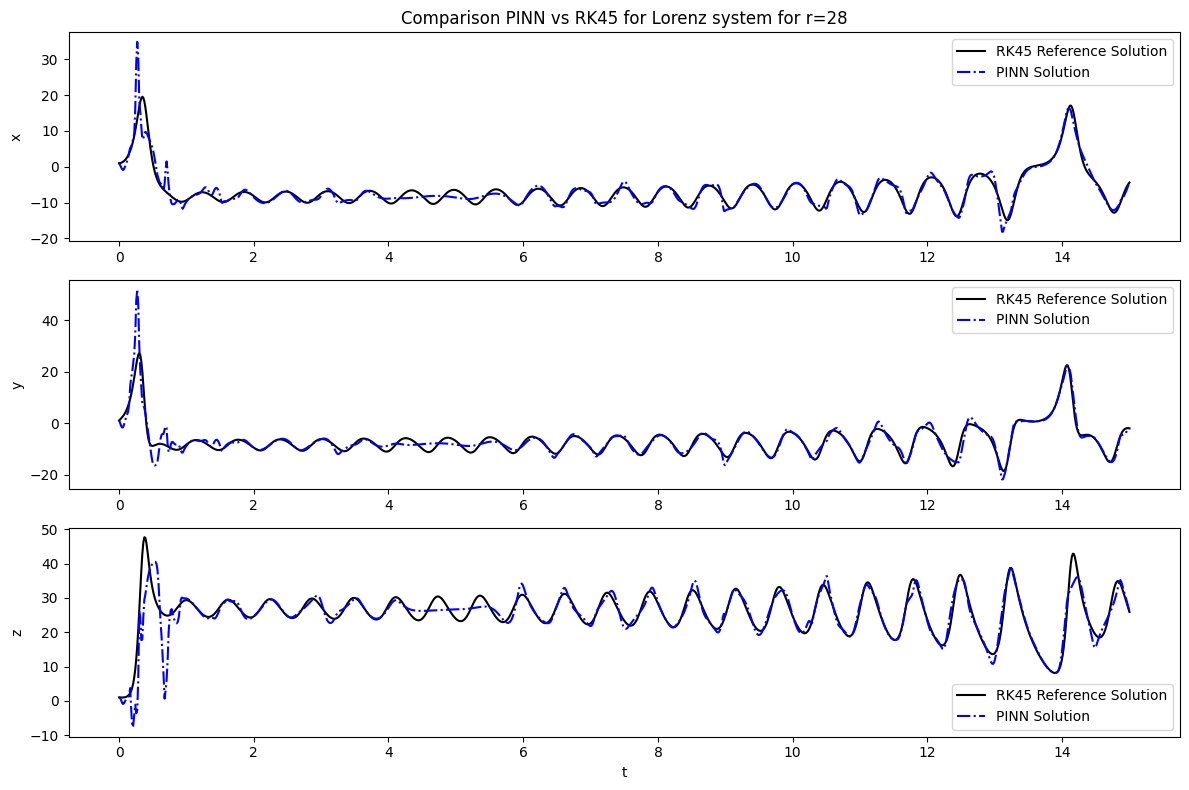

In [11]:
title_r0 = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_base_IC_r0,
    pinn_solution=y_pinn_base_IC_r0,
    title=title_r0
)

#### Anfangsbedigung (10, -5, 20)
Diese Anfangsbedingung liegt relativ weit von möglichen Fixpunkten des Systems entfernt und soll Anfangsbedingungen mit relativ hohen Werten repräsentieren.

In [ ]:
high_IC = np.array([10.0, -5.0, 20.0], dtype=np.float32)
t_eval, sol_rk45_high_IC_r0 = hf.ref_solution(A, B_0, C, t_min, t_max, high_IC)
model_high_IC_r0 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
t_data, y_data = hf.generate_noisy_data(sol_rk45_base_IC_r0, t_min, t_max)

In [13]:
pinn.train(
    model_high_IC_r0,
    t_initial=t_min,
    initial_conditions=high_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=True
)


Training started...
Epoch     0 | Loss: 1.3837e+02 | Data/IC-Loss: 2.7574e+02 | Physics-Loss: 9.9999e-01
Epoch  1000 | Loss: 7.0366e+00 | Data/IC-Loss: 1.3073e+01 | Physics-Loss: 1.0000e+00
Epoch  2000 | Loss: 3.7117e+00 | Data/IC-Loss: 6.4233e+00 | Physics-Loss: 1.0000e+00
Epoch  3000 | Loss: 2.5915e+00 | Data/IC-Loss: 4.1830e+00 | Physics-Loss: 1.0000e+00
Epoch  4000 | Loss: 1.9527e+00 | Data/IC-Loss: 2.9053e+00 | Physics-Loss: 1.0000e+00
Epoch  5000 | Loss: 1.4421e+00 | Data/IC-Loss: 1.8841e+00 | Physics-Loss: 1.0000e+00
Epoch  6000 | Loss: 1.5122e+00 | Data/IC-Loss: 2.0244e+00 | Physics-Loss: 1.0000e+00
Epoch  7000 | Loss: 1.2533e+00 | Data/IC-Loss: 1.5066e+00 | Physics-Loss: 1.0000e+00
Epoch  8000 | Loss: 1.2190e+00 | Data/IC-Loss: 1.4380e+00 | Physics-Loss: 1.0000e+00
Epoch  9000 | Loss: 1.1914e+00 | Data/IC-Loss: 1.3828e+00 | Physics-Loss: 1.0000e+00
Epoch 10000 | Loss: 1.1596e+00 | Data/IC-Loss: 1.3192e+00 | Physics-Loss: 1.0000e+00
Epoch 11000 | Loss: 1.1325e+00 | Data/IC-Loss

In [ ]:
y_pinn_high_IC_r0, _ = pinn.pinn_predict(model_high_IC_r0, t_eval, t_min, t_max, normalize_input=True, A=A, B=B_0, C=C)
ic_mse_high_IC_r0 = pinn_ic_mse(sol_rk45_high_IC_r0, y_pinn_high_IC_r0)
reference_mse_high_IC_r0 = pinn_reference_mse(sol_rk45_high_IC_r0, y_pinn_high_IC_r0)

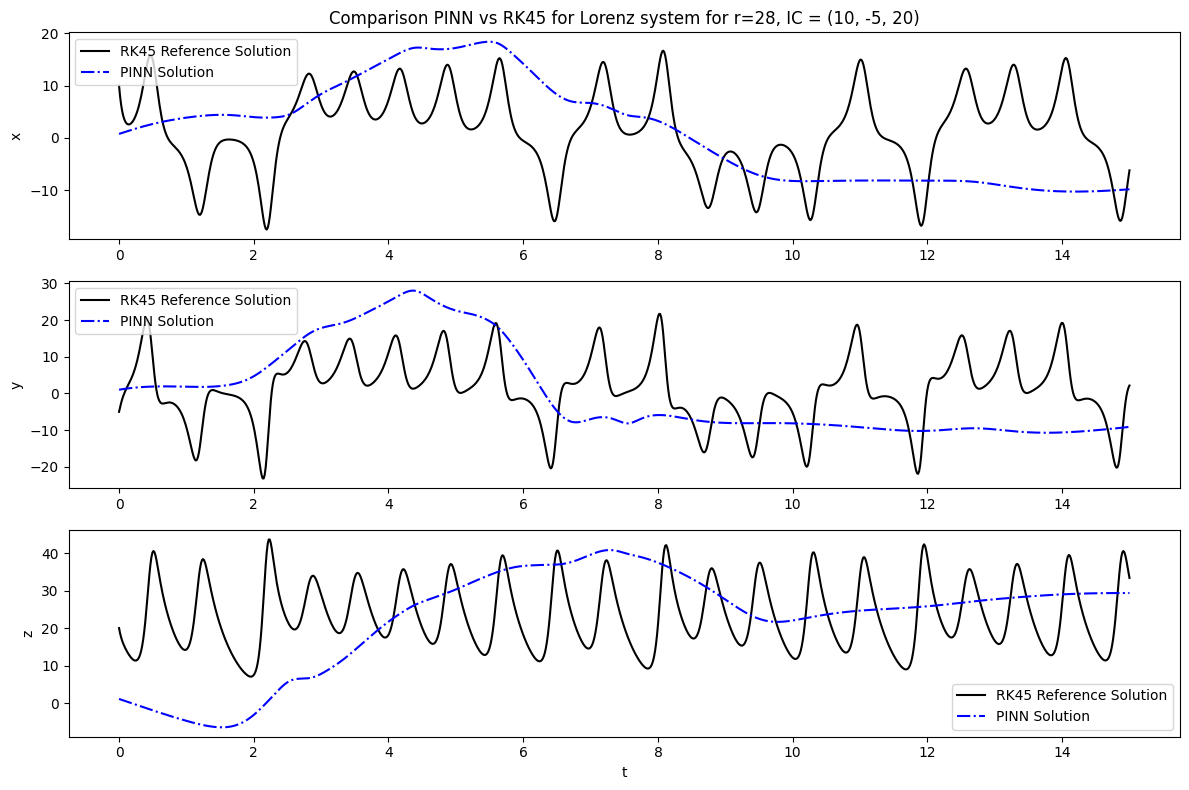

In [15]:
title = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}, IC = (10, -5, 20)"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_high_IC_r0,
    pinn_solution=y_pinn_high_IC_r0,
    title=title
)

#### Anfangsbedingung (0, 1, 0)
Von Lorenz gewählte Anfangsbedingung.

In [16]:
lorenz_IC = np.array([0.0, 1.0, 0.0], dtype=np.float32)
t_eval, sol_rk45_lorenz_IC_r0 = hf.ref_solution(A, B_0, C, t_min, t_max, lorenz_IC)
model_lorenz_IC_r0 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
t_data, y_data = hf.generate_noisy_data(sol_rk45_base_IC_r0, t_min, t_max)

In [17]:
pinn.train(
    model_lorenz_IC_r0,
    t_initial=t_min,
    initial_conditions=lorenz_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=True
    )


Training started...
Epoch     0 | Loss: 1.4084e+02 | Data/IC-Loss: 2.8068e+02 | Physics-Loss: 9.9999e-01
Epoch  1000 | Loss: 7.3933e+00 | Data/IC-Loss: 1.3787e+01 | Physics-Loss: 1.0000e+00
Epoch  2000 | Loss: 3.4290e+00 | Data/IC-Loss: 5.8580e+00 | Physics-Loss: 1.0000e+00
Epoch  3000 | Loss: 3.8812e+00 | Data/IC-Loss: 6.7624e+00 | Physics-Loss: 1.0000e+00
Epoch  4000 | Loss: 2.3045e+00 | Data/IC-Loss: 3.6089e+00 | Physics-Loss: 1.0000e+00
Epoch  5000 | Loss: 2.1444e+00 | Data/IC-Loss: 3.2888e+00 | Physics-Loss: 1.0000e+00
Epoch  6000 | Loss: 1.7363e+00 | Data/IC-Loss: 2.4726e+00 | Physics-Loss: 1.0000e+00
Epoch  7000 | Loss: 1.5035e+00 | Data/IC-Loss: 2.0070e+00 | Physics-Loss: 1.0000e+00
Epoch  8000 | Loss: 1.4285e+00 | Data/IC-Loss: 1.8571e+00 | Physics-Loss: 1.0000e+00
Epoch  9000 | Loss: 1.2810e+00 | Data/IC-Loss: 1.5620e+00 | Physics-Loss: 1.0000e+00
Epoch 10000 | Loss: 1.1169e+00 | Data/IC-Loss: 1.2338e+00 | Physics-Loss: 1.0000e+00
Epoch 11000 | Loss: 1.0354e+00 | Data/IC-Loss

In [30]:
y_pinn_lorenz_IC_r0, _ = pinn.pinn_predict(model_lorenz_IC_r0, t_eval, t_min, t_max, normalize_input=True, A=A, B=B_0, C=C)
ic_mse_lorenz_IC_r0 = pinn_ic_mse(sol_rk45_lorenz_IC_r0, y_pinn_lorenz_IC_r0)
reference_mse_lorenz_IC_r0 = pinn_reference_mse(sol_rk45_lorenz_IC_r0, y_pinn_lorenz_IC_r0)


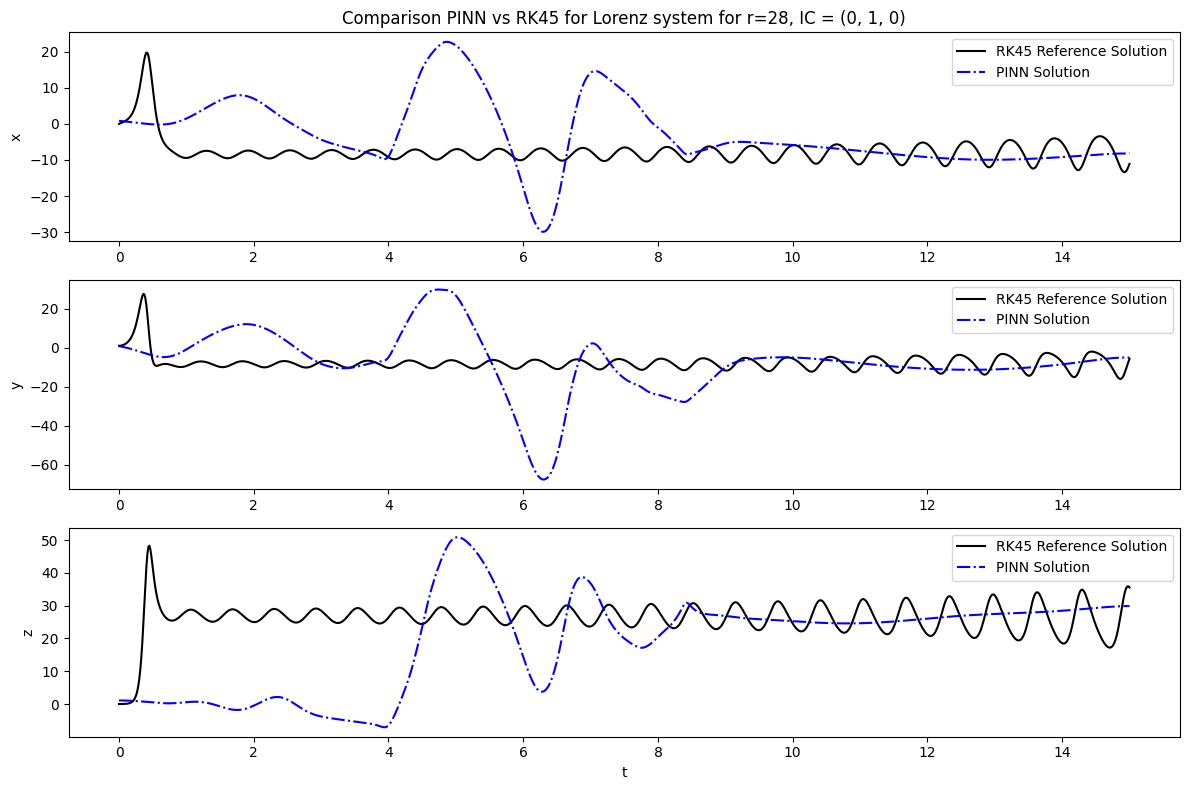

In [31]:
title = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}, IC = (0, 1, 0)"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_lorenz_IC_r0,
    pinn_solution=y_pinn_lorenz_IC_r0,
    title=title
)

#### Anfangsbedingung (0, 1.0001, 0)
Minimal abweichende Anfangsbedingung. 

In [23]:
sensitive_IC = np.array([0.0, 1.0001, 0.0], dtype=np.float32)
t_eval, sol_rk45_sensitive_IC_r0 = hf.ref_solution(A, B_0, C, t_min, t_max, sensitive_IC)

model_sensitive_IC_r0 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
t_data, y_data = hf.generate_noisy_data(sol_rk45_base_IC_r0, t_min, t_max)

In [24]:
pinn.train(
    model_sensitive_IC_r0,
    t_initial=t_min,
    initial_conditions=sensitive_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=4000,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=True
    )


Training started...
Epoch     0 | Loss: 1.4142e+02 | Data/IC-Loss: 2.8185e+02 | Physics-Loss: 9.9999e-01
Epoch  1000 | Loss: 1.0120e+01 | Data/IC-Loss: 1.9239e+01 | Physics-Loss: 1.0000e+00
Epoch  2000 | Loss: 9.3595e+00 | Data/IC-Loss: 1.7719e+01 | Physics-Loss: 1.0000e+00
Epoch  3000 | Loss: 5.9405e+00 | Data/IC-Loss: 1.0881e+01 | Physics-Loss: 1.0000e+00
Epoch  3999 | Loss: 4.9706e+00 | Data/IC-Loss: 8.9411e+00 | Physics-Loss: 1.0000e+00
Training finished!


In [41]:
y_pinn_sensitive_IC_r0,_ = pinn.pinn_predict(model_sensitive_IC_r0, t_eval, t_min, t_max, normalize_input=True, A=A, B=B_0, C=C)
ic_mse_sensitive_IC_r0 = pinn_ic_mse(sol_rk45_sensitive_IC_r0, y_pinn_sensitive_IC_r0)
reference_mse_sensitive_IC_r0 = pinn_reference_mse(sol_rk45_sensitive_IC_r0, y_pinn_sensitive_IC_r0)

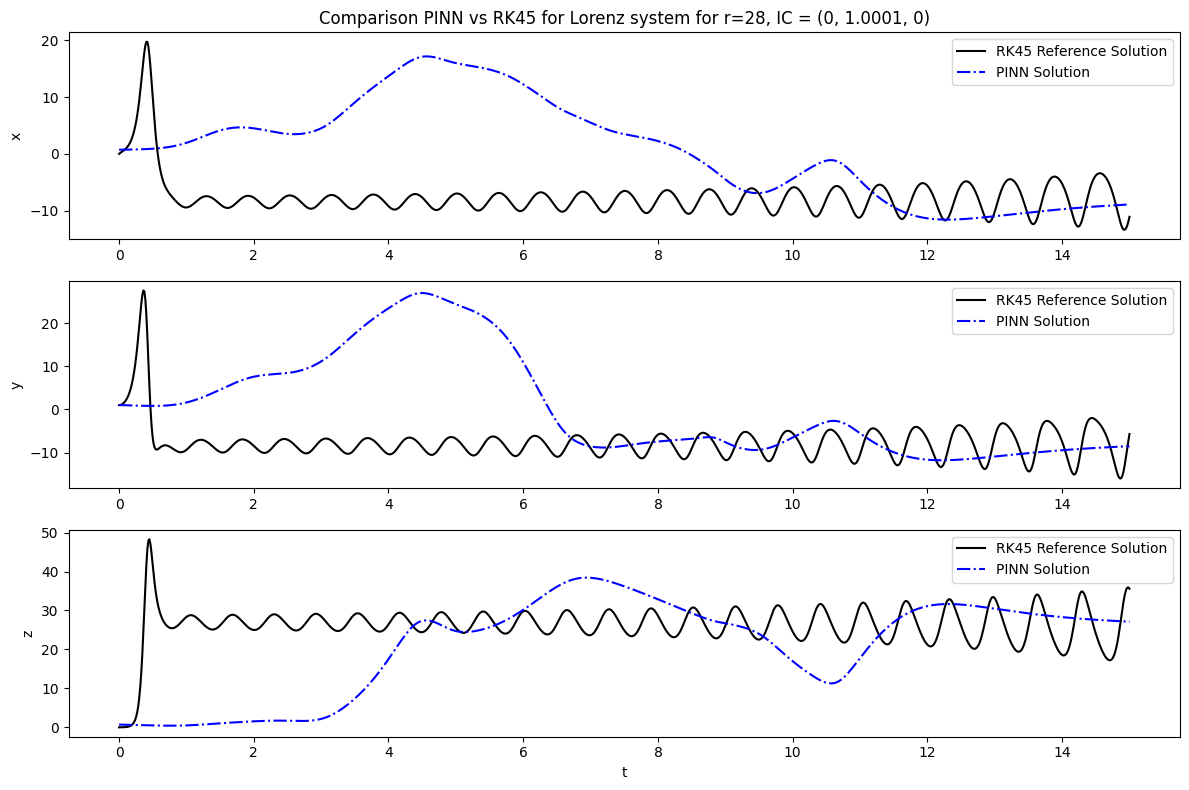

In [42]:
title = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}, IC = (0, 1.0001, 0)"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_sensitive_IC_r0,
    pinn_solution=y_pinn_sensitive_IC_r0,
    title=title
)

####  Anfangsbedingung (0.5, 0.5, 0.1)
Anfangsbedingung in der Nähe eines Fixpunktes der für r > 1 entsteht. 

In [38]:
c_plus_IC = np.array([0.5, 0.5, 0.1], dtype=np.float32)
t_eval, sol_rk45_c_plus_IC_r0 = hf.ref_solution(A, B_0, C, t_min, t_max, c_plus_IC)


model_c_plus_IC_r0 = phf.build_pinn_network(HIDDEN_LAYER, NEURONS_PER_LAYER, ACTIVATION_FUNCTION, WEIGHT_INITIALIZATION)
t_data, y_data = hf.generate_noisy_data(sol_rk45_base_IC_r0, t_min, t_max)

In [39]:
pinn.train(
    model_c_plus_IC_r0,
    t_initial=t_min,
    initial_conditions=c_plus_IC,
    A=A, B=B_0, C=C,
    t_min=t_min, t_max=t_max,
    collocation_points=COLLOCATION_POINTS,
    alpha=ALPHA_DATA,
    learning_rate=LEARNING_RATE,
    decay_rate=DECAY_RATE,
    epochs=EPOCHS,
    optimizer_class=OPTIMIZER,
    normalize_input=True,
    data_active=True,
    t_data=t_data,
    y_data=y_data,
    chaotic=True
    )


Training started...
Epoch     0 | Loss: 1.4161e+02 | Data/IC-Loss: 2.8222e+02 | Physics-Loss: 9.9999e-01
Epoch  1000 | Loss: 7.2971e+00 | Data/IC-Loss: 1.3594e+01 | Physics-Loss: 1.0000e+00
Epoch  2000 | Loss: 5.0467e+00 | Data/IC-Loss: 9.0934e+00 | Physics-Loss: 1.0000e+00
Epoch  3000 | Loss: 3.5620e+00 | Data/IC-Loss: 6.1241e+00 | Physics-Loss: 1.0000e+00
Epoch  4000 | Loss: 1.4195e+00 | Data/IC-Loss: 1.8391e+00 | Physics-Loss: 1.0000e+00
Epoch  5000 | Loss: 1.0860e+00 | Data/IC-Loss: 1.1719e+00 | Physics-Loss: 1.0000e+00
Epoch  6000 | Loss: 9.3062e-01 | Data/IC-Loss: 8.6125e-01 | Physics-Loss: 1.0000e+00
Epoch  7000 | Loss: 8.7265e-01 | Data/IC-Loss: 7.4529e-01 | Physics-Loss: 1.0000e+00
Epoch  8000 | Loss: 8.5716e-01 | Data/IC-Loss: 7.1432e-01 | Physics-Loss: 1.0000e+00
Epoch  9000 | Loss: 8.1853e-01 | Data/IC-Loss: 6.3706e-01 | Physics-Loss: 1.0000e+00
Epoch 10000 | Loss: 8.4851e-01 | Data/IC-Loss: 6.9702e-01 | Physics-Loss: 1.0000e+00
Epoch 11000 | Loss: 7.9238e-01 | Data/IC-Loss

In [43]:
y_pinn_c_plus_IC_r0, _ = pinn.pinn_predict(model_c_plus_IC_r0, t_eval, t_min, t_max, normalize_input=True, A=A, B=B_0, C=C)
ic_mse_c_plus_IC_r0 = pinn_ic_mse(sol_rk45_c_plus_IC_r0, y_pinn_c_plus_IC_r0)
reference_mse_c_plus_r0 = pinn_reference_mse(sol_rk45_c_plus_IC_r0, y_pinn_c_plus_IC_r0)


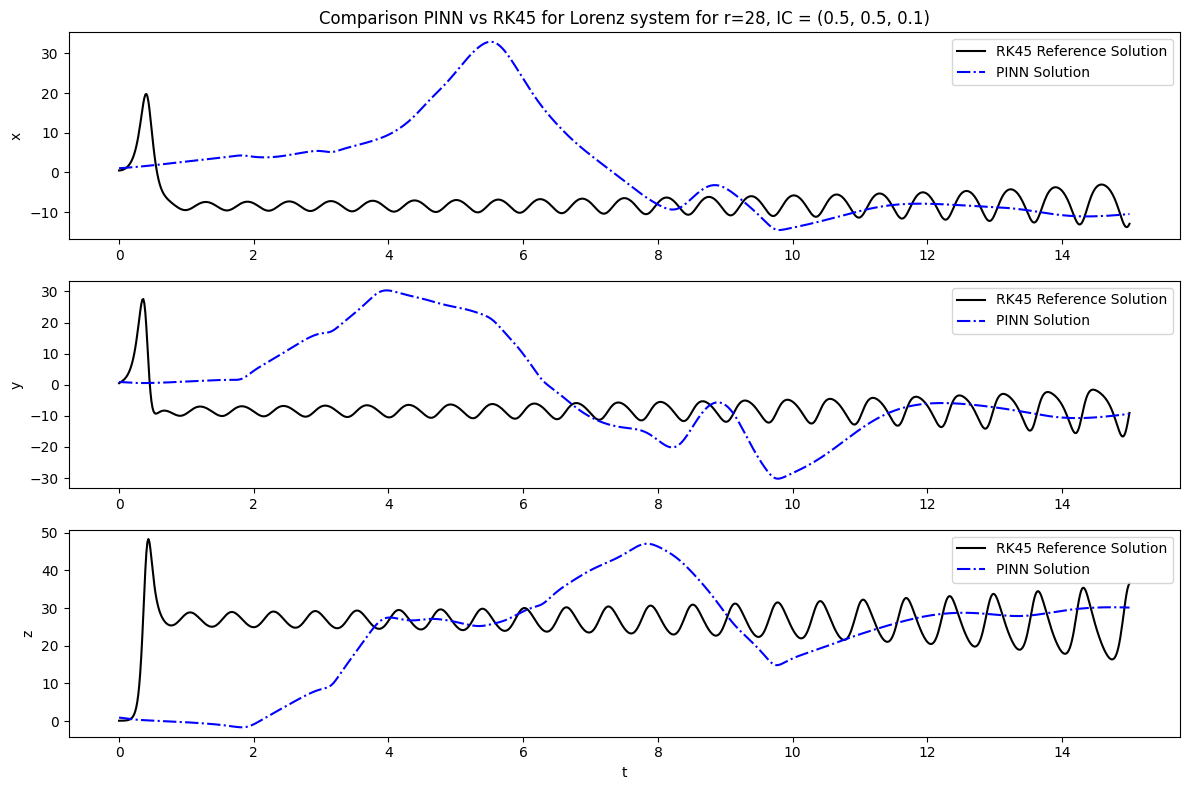

In [44]:
title = f"Comparison PINN vs RK45 for Lorenz system for r={B_0}, IC = (0.5, 0.5, 0.1)"
x_y_z_plotter(
    t_eval=t_eval,
    solution_rk45=sol_rk45_c_plus_IC_r0,
    pinn_solution=y_pinn_c_plus_IC_r0,
    title=title
)